# Exploring Pythia training dynamics with HMM latent models

**(2) Metrics for LEACE predicting gender in Pythia's input embeddings**

In [1]:
# Here we collect all the regression tables (name->DataFrame) for the summary table in the end.
from collections import defaultdict

regression_tables = defaultdict(list)

## Pythia 70m

In [2]:
# First, test if the input embeddings contain linearly decodable gender information,
# and whether LEACE can remove this.
# Following procedure from: https://github.com/EleutherAI/concept-erasure

from extract_metrics import SimpleGenderEraser
from lm_checkpoints import PythiaCheckpoints
from sklearn.linear_model import LogisticRegression
import pandas as pd
import torch

results = []

for ckpt in PythiaCheckpoints.final_checkpoints(size=70):
    eraser = SimpleGenderEraser(ckpt.model, ckpt.tokenizer)
    X, Y = eraser.data

    # Logistic regression does learn something before concept erasure
    real_lr = LogisticRegression(max_iter=1000).fit(X, Y)
    beta_before = torch.from_numpy(real_lr.coef_).norm(p=torch.inf)

    X_ = eraser.get_eraser()(X)

    # But learns nothing after
    null_lr = LogisticRegression(max_iter=1000, tol=0.0).fit(X_.numpy(), Y)
    beta_after = torch.from_numpy(null_lr.coef_).norm(p=torch.inf)

    results.append({"seed": ckpt.config["seed"], "beta_norm_before": beta_before.item(), "beta_norm_after": beta_after.item()})

pd.DataFrame(results).set_index("seed")

2023-11-28 14:24:42,363	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.7.2 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


,beta_norm_before,beta_norm_after
seed,,
0,0.374715,0.000084
1,0.436526,0.000002
2,0.389981,0.000002
3,0.537576,0.000002
4,0.420666,0.000002


In [3]:
import pandas as pd
from training_map import HMMTrainingMapSelection

df_ = pd.read_csv("results/Pythia70m_input_embeddings_gender_LEACE_metrics.tsv", sep="\t").drop(columns=["sigma_lambda"])
TS_70m = HMMTrainingMapSelection(df_)
TS_70m.show_model_selection()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Model is not converging.  Current: -7233.386900369354 is not greater than -7233.386898056833. Delta is -2.3125212464947253e-06
Model is not converging.  Current: -7233.386900369354 is not greater than -7233.386847312509. Delta is -5.305684499035124e-05
Model is not converging.  Current: -7233.386900369354 is not greater than -7233.38689782533. Delta is -2.5440240278840065e-06
Model is not converging.  Current: -7233.386900369354 is not greater than -7233.38690033881. Delta is -3.054447006434202e-08
Model is not converging.  Current: -7233.386900369354 is not greater than -7233.3868417129615. Delta is -5.8656392866396345e-05
Model is not converging.  Current: -1435.070

alt.LayerChart(...)

### N=3 components

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


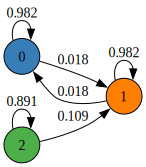

In [21]:
# Select N=3 components from model selection plot above
training_map = TS_70m.get_training_map(3)
training_map.show()

In [5]:
# Visualizing a random metric used for training the HMM.
training_map.show_training_states("trace")

alt.FacetChart(...)

#### Train loss
Unfortunately, WandB has not always stored the train loss correctly (connection issues?).

In [6]:
from utils import load_loss

df_loss_70m = load_loss("results/loss/Pythia/train_loss_70m_seed{}.csv", last_steps=False)
training_map.show_training_states("train loss", data=df_loss_70m)

alt.FacetChart(...)

We do linear regression for the bag of states distribution and the final train loss.
Because the train loss is missing for some checkpoints, we correlate with the average over all ckpt >142900.

In [7]:
from utils import regression_table, load_loss

X = training_map.bag_of_states_distributions
y = load_loss("results/loss/Pythia/train_loss_70m_seed{}.csv")

regression_tables["70m/4states/all"].append(regression_table(X, y, color=False))
regression_table(X, y, color=True)

,task,R^2,F-statistic,F-statistic P-value
0,train loss,0.69,2.27,0.31


### Downstream performance: LAMBADA SWAG PIQA ARC

In [8]:
from utils import regression_table, load_results

X = training_map.bag_of_states_distributions
y = load_results("results/eval-harness/Pythia/downstream_70m_seed{}.json")

regression_tables["70m/4states/all"].append(regression_table(X, y, color=False))
regression_table(X, y, color=True)

,task,metric,R^2,F-statistic,F-statistic P-value
0,arc_challenge,acc,0.75,2.94,0.25
1,arc_easy,acc,0.35,0.53,0.65
2,lambada_openai,acc,0.81,4.24,0.19
3,piqa,acc,0.64,1.81,0.36
4,swag,acc,0.65,1.84,0.35


### Gender: BLiMP and CrowS-Pairs

In [9]:
from utils import load_results

X = training_map.bag_of_states_distributions
y = load_results("results/eval-harness/Pythia/gender_70m_seed{}.json")

regression_tables["70m/4states/all"].append(regression_table(X, y, color=False))
regression_table(X, y, color=True)

,task,metric,R^2,F-statistic,F-statistic P-value
0,blimp_anaphor_gender_agreement,acc,0.61,1.59,0.39
1,crows_pairs_english,likelihood_diff,0.63,1.73,0.37
2,crows_pairs_english,pct_stereotype,0.22,0.28,0.78
3,crows_pairs_english_gender,likelihood_diff,0.21,0.27,0.79
4,crows_pairs_english_gender,pct_stereotype,0.57,1.31,0.43


## Pythia 160m

In [10]:
# First, test if the input embeddings contain gender information,
# and whether LEACE can remove this.
# Following procedure from: https://github.com/EleutherAI/concept-erasure

from extract_metrics import SimpleGenderEraser
from lm_checkpoints import PythiaCheckpoints
from sklearn.linear_model import LogisticRegression
import pandas as pd
import torch

results = []

for ckpt in PythiaCheckpoints.final_checkpoints(size=160):
    eraser = SimpleGenderEraser(ckpt.model, ckpt.tokenizer)
    X, Y = eraser.data

    # Logistic regression does learn something before concept erasure
    real_lr = LogisticRegression(max_iter=1000).fit(X, Y)
    beta_before = torch.from_numpy(real_lr.coef_).norm(p=torch.inf)

    X_ = eraser.get_eraser()(X)

    # But learns nothing after
    null_lr = LogisticRegression(max_iter=1000, tol=0.0).fit(X_.numpy(), Y)
    beta_after = torch.from_numpy(null_lr.coef_).norm(p=torch.inf)

    results.append({"seed": ckpt.config["seed"], "beta_norm_before": beta_before.item(), "beta_norm_after": beta_after.item()})

pd.DataFrame(results).set_index("seed")

,beta_norm_before,beta_norm_after
seed,,
0,0.336849,0.000002
1,0.354040,0.000002
2,0.450666,0.000002
3,0.328234,0.000002
4,0.394330,0.000002


In [11]:
import pandas as pd
from training_map import HMMTrainingMapSelection

df_ = pd.read_csv("results/Pythia160m_input_embeddings_gender_LEACE_metrics.tsv", sep="\t").drop(columns=["sigma_lambda"])
TS_160m = HMMTrainingMapSelection(df_)
TS_160m.show_model_selection()

Model is not converging.  Current: -1623.1601658358466 is not greater than -1623.1332751352732. Delta is -0.026890700573403592
Model is not converging.  Current: -427.0469365693734 is not greater than -427.0386919963972. Delta is -0.008244572976195741
Model is not converging.  Current: 194.21362954245507 is not greater than 194.21572204496013. Delta is -0.002092502505064431
Model is not converging.  Current: -67.33284852062275 is not greater than -67.3248907236449. Delta is -0.007957796977848375


alt.LayerChart(...)

### N=4 components: all

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


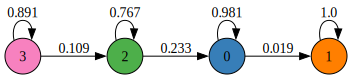

In [12]:
# Select 4 components
training_map = TS_160m.get_training_map(4)
training_map.show()

In [13]:
training_map.show_training_states("trace")

alt.FacetChart(...)

#### Downstream performance

In [14]:
from utils import regression_table

X = training_map.bag_of_states_distributions
y = load_results("results/eval-harness/Pythia/downstream_160m_seed{}.json")

regression_tables["160m/4states/all"].append(regression_table(X, y, color=False))
regression_table(X, y, color=True)

,task,metric,R^2,F-statistic,F-statistic P-value
0,arc_challenge,acc,0.44,0.26,0.86
1,arc_easy,acc,0.79,1.26,0.56
2,lambada_openai,acc,0.91,3.55,0.37
3,piqa,acc,0.95,6.87,0.27
4,swag,acc,0.98,21.76,0.16


#### Gender (Bias)

In [15]:
from utils import regression_table

X = training_map.bag_of_states_distributions
y = load_results("results/eval-harness/Pythia/gender_160m_seed{}.json")

regression_tables["160m/4states/all"].append(regression_table(X, y, color=False))
regression_table(X, y, color=True)

,task,metric,R^2,F-statistic,F-statistic P-value
0,blimp_anaphor_gender_agreement,acc,0.48,0.31,0.83
1,crows_pairs_english,likelihood_diff,0.75,1.00,0.61
2,crows_pairs_english,pct_stereotype,0.99,29.54,0.13
3,crows_pairs_english_gender,likelihood_diff,0.82,1.51,0.52
4,crows_pairs_english_gender,pct_stereotype,0.41,0.23,0.87


### N=7 components: Detour states

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


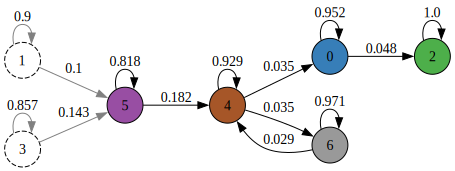

In [16]:
training_map = TS_160m.get_training_map(7)
training_map.show(model_seed=4)

For N=7 components, we find 6 detour states (num of columns):

In [17]:
training_map.detour_states

array([[0.        , 0.07142857, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.16883117, 0.        , 0.22727273, 0.        , 0.21428571,
        0.28571429]])

In [18]:
from utils import regression_table

X_detour = training_map.detour_states
y = load_results("results/eval-harness/Pythia/downstream_160m_seed{}.json")

regression_tables["160m/7states/detour"].append(regression_table(X_detour, y, color=False))
regression_table(X_detour, y, color=True)

,task,metric,R^2,F-statistic,F-statistic P-value
0,arc_challenge,acc,0.41,1.06,0.45
1,arc_easy,acc,0.39,0.97,0.47
2,lambada_openai,acc,0.41,1.05,0.45
3,piqa,acc,0.40,0.99,0.47
4,swag,acc,0.39,0.97,0.47


In [19]:
from utils import regression_table

X_detour = training_map.detour_states
y = load_results("results/eval-harness/Pythia/gender_160m_seed{}.json")

regression_tables["160m/7states/detour"].append(regression_table(X_detour, y, color=False))
regression_table(X_detour, y, color=True)

,task,metric,R^2,F-statistic,F-statistic P-value
0,blimp_anaphor_gender_agreement,acc,0.40,0.99,0.47
1,crows_pairs_english,likelihood_diff,0.40,0.98,0.47
2,crows_pairs_english,pct_stereotype,0.40,1.01,0.46
3,crows_pairs_english_gender,likelihood_diff,0.39,0.97,0.47
4,crows_pairs_english_gender,pct_stereotype,0.41,1.05,0.45


## Summary
Table with R^2 values. Missing information on significance.

In [20]:
from utils import combine_regression_tables

tables = []
names = []

for name, dfs in regression_tables.items():
    names.append(name)
    tables.append(pd.concat(dfs).drop_duplicates())

combine_regression_tables(tables, names)